In [1]:
# Some part borrowed from official tutorial https://github.com/pytorch/examples/blob/master/imagenet/main.py
from __future__ import print_function
from __future__ import absolute_import

import os
import numpy as np
import argparse
import importlib
import time
import logging
import warnings
from collections import OrderedDict
import pdb
import importlib

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import models
import data
import trainers
import evaluators
import attacks
from attack_vectors import get_attack_vector
from utils import *

import sklearn
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt

import CKA


In [2]:
cifar = data.cifar10('./datasets', normalize=False)
# imagenet = data.imagenet('./datasets/imagenette2', normalize=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = "cuda:0"
in_channel = 3
num_classes = 10
config_path_none = './configs/configs_cifar.yml'
config_path_025 = './configs/configs_cifar0.25.yml'
config_path_050 = './configs/configs_cifar0.5.yml'
config_path_100 = './configs/configs_cifar1.yml'
config_path_150 = './configs/configs_cifar1.5.yml'
config_path_200 = './configs/configs_cifar2.yml'

In [4]:
cifar_none = './trained_models/cifar10_ResNet18_base/trial_0/checkpoint/checkpoint.pth.tar'
cifar_025 = './trained_models/cifar10_ResNet18_l2_0.25/trial_0/checkpoint/checkpoint.pth.tar'
cifar_050 = './trained_models/cifar10_ResNet18_l2_0.5/trial_0/checkpoint/checkpoint.pth.tar'
cifar_100 = './trained_models/cifar10_ResNet18_l2_1/trial_0/checkpoint/checkpoint.pth.tar'
cifar_150 = './trained_models/cifar10_ResNet18_l2_1.5/trial_0/checkpoint/checkpoint.pth.tar'
cifar_200 = './trained_models/cifar10_ResNet18_l2_2/trial_0/checkpoint/checkpoint.pth.tar'

In [5]:
cifar_models = []
for cifar_weights in [cifar_none, cifar_025, cifar_050, cifar_100, cifar_150, cifar_200]:
    m = torch.nn.DataParallel(models.ResNet18(in_channel=in_channel, num_classes=num_classes)).cuda().eval()
    ckpt_dict = torch.load(cifar_weights, map_location="cpu")["state_dict"]
    m.load_state_dict(ckpt_dict)
    cifar_models.append(m)

In [6]:
def get_images(imgs):
    images = []
    for x,y in enumerate(imgs[1]):
        images.append(y)
    
    image_data = None
    image_labels = None
    for batch in range(len(images)):
        if image_data is None:
            image_data = images[batch][0]
            image_labels = images[batch][1]
        else:
            image_data = torch.cat((image_data, images[batch][0]), 0)
            image_labels = torch.cat((image_labels, images[batch][1]), 0)
    image_data = image_data.to(device)
    image_labels = image_labels.to(device)
    return images, image_data, image_labels

In [7]:
cifar_images, cifar_image_data, cifar_image_labels = get_images(cifar)
perm = torch.randperm(10000)
cifar_image_data = cifar_image_data[perm]
cifar_image_labels = cifar_image_labels[perm]
print(cifar_image_data.shape, cifar_image_labels.shape)

torch.Size([10000, 3, 32, 32]) torch.Size([10000])


In [8]:
with open(config_path_none, 'r') as f:
    args_none = EasyDict(yaml.load(f))

with open(config_path_025, 'r') as f:
    args_025 = EasyDict(yaml.load(f))

with open(config_path_050, 'r') as f:
    args_050 = EasyDict(yaml.load(f))

with open(config_path_100, 'r') as f:
    args_100 = EasyDict(yaml.load(f))

with open(config_path_150, 'r') as f:
    args_150 = EasyDict(yaml.load(f))

with open(config_path_200, 'r') as f:
    args_200 = EasyDict(yaml.load(f))

In [9]:
cifar_preds = []
num_images = 3000
cifar_image_data = cifar_image_data[:num_images]
cifar_image_labels = cifar_image_labels[:num_images]
for m in cifar_models:
    cifar_preds.append(m(cifar_image_data, all=True))
# torch.sum(torch.argmax(cifar_preds[0][0], axis=1) == cifar_image_labels)
benign_acts = [None] * len(cifar_models)
for i in range(len(cifar_models)):
    acts = cifar_preds[i][1]['layer4']['block_1']['conv2'].cpu().detach().numpy().reshape((num_images,512))
    benign_acts[i] = acts

In [10]:
attack_none = get_attack_vector('l2', args_none.EvalAttack)
attack_025 = get_attack_vector('l2', args_025.EvalAttack)
attack_050 = get_attack_vector('l2', args_050.EvalAttack)
attack_100 = get_attack_vector('l2', args_100.EvalAttack)
attack_150 = get_attack_vector('l2', args_150.EvalAttack)
attack_200 = get_attack_vector('l2', args_200.EvalAttack)

attacks = [attack_none, attack_025, attack_050, attack_100, attack_150, attack_200]
adv_images = []
for i in range(len(cifar_models)):
    images_m = []
    for j in range(len(attacks)):
        if j == 0:
            images_m.append(cifar_image_data)
        else:
            images_m.append(attacks[j](cifar_models[i], cifar_image_data, cifar_image_labels, torch.ones(num_images))[0])
    adv_images.append(images_m)

In [11]:
adv_acts = []
for m in range(len(cifar_models)):
    acts_m = []
    for attack in range(len(attacks)):
        preds = cifar_models[m](adv_images[m][attack], all=True)
        acts_m.append(preds[1]['layer4']['block_1']['conv2'].cpu().detach().numpy().reshape((num_images,512)))
    adv_acts.append(acts_m)


In [12]:
strengths = ['base', '0.25', '0.5', '1.0', '1.5', '2.0']
heatmap_data = []
for i in range(len(cifar_models)):
    heatmap_m = []
    for j in range(len(attacks)):
        # print('Model ' + strengths[i] + ' vs Model ' + strengths[j])
        cka = CKA.feature_space_linear_cka(adv_acts[i][i], adv_acts[j][j])
        # cka = CKA.feature_space_linear_cka(benign_acts[i], benign_acts[j])
        # print(str(cka))
        # print()
        heatmap_m.append(cka)
    heatmap_data.append(heatmap_m)

    # print()


<function matplotlib.pyplot.show(close=None, block=None)>

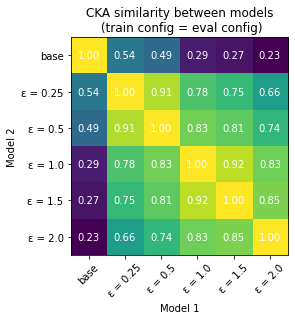

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(heatmap_data)

model_names = ['base', '\u03b5 = 0.25', '\u03b5 = 0.5', '\u03b5 = 1.0', '\u03b5 = 1.5', '\u03b5 = 2.0']

ax.set_title('CKA similarity between models\n (train config = eval config)')

ax.set_xlabel('Model 1')
ax.set_ylabel('Model 2')
ax.set_xticks(np.arange(len(model_names)))
ax.set_yticks(np.arange(len(model_names)))
ax.set_xticklabels(model_names, rotation=45)
ax.set_yticklabels(model_names)

for i in range(len(cifar_models)):
    for j in range(len(cifar_models)):
        text = ax.text(i, j, '{:.2f}'.format(heatmap_data[i][j]),
                       ha="center", va="center", color="w")

plt.show

In [14]:
strengths = ['base', '0.25', '0.5', '1.0', '1.5', '2.0']
heatmap_data2 = []
for i in range(len(cifar_models)):
    heatmap_m = []
    for j in range(len(attacks)):
        # print('Model ' + strengths[i] + ' vs Model ' + strengths[j])
        cka = CKA.feature_space_linear_cka(adv_acts[i][i], adv_acts[i][j])
        # cka = CKA.feature_space_linear_cka(benign_acts[i], benign_acts[j])
        # print(str(cka))
        # print()
        heatmap_m.append(cka)
    heatmap_data2.append(heatmap_m)

    # print()


<function matplotlib.pyplot.show(close=None, block=None)>

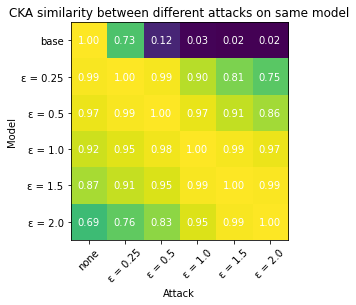

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(heatmap_data2)

model_names = ['base', '\u03b5 = 0.25', '\u03b5 = 0.5', '\u03b5 = 1.0', '\u03b5 = 1.5', '\u03b5 = 2.0']
attack_names = ['none', '\u03b5 = 0.25', '\u03b5 = 0.5', '\u03b5 = 1.0', '\u03b5 = 1.5', '\u03b5 = 2.0']

ax.set_title('CKA similarity between different attacks on same model')

ax.set_xlabel('Attack')
ax.set_ylabel('Model')
ax.set_xticks(np.arange(len(attack_names)))
ax.set_yticks(np.arange(len(model_names)))
ax.set_xticklabels(attack_names, rotation=45)
ax.set_yticklabels(model_names)

for i in range(len(cifar_models)):
    for j in range(len(cifar_models)):
        text = ax.text(j, i, '{:.2f}'.format(heatmap_data2[i][j]),
                       ha="center", va="center", color="w")

plt.show

In [16]:

# epsilons = [0, 0.25, 0.5, 1, 1.5, 2]
# for e in range(1,6):
#     epsilon = epsilons[e]
#     print('\u03b5 =',epsilon)
#     random_noise = torch.FloatTensor(cifar_image_data.shape).uniform_(-1, 1).to(device).detach()
#     random_noise.renorm_(p=2, dim=0, maxnorm=epsilon)
#     noisy_image_data = cifar_image_data + random_noise
#     base_model = cifar_models[0]
#     noisy_preds = base_model(noisy_image_data, all=True)
#     noisy_acts = noisy_preds[1]['layer4']['block_1']['conv2'].cpu().detach().numpy().reshape((num_images,512))
#     print('CKA (base vs adv):', CKA.feature_space_linear_cka(adv_acts[0][0], adv_acts[0][e]))
#     print('CKA (base vs noisy):', CKA.feature_space_linear_cka(adv_acts[0][0], noisy_acts))
#     print()


In [17]:
torch.norm(adv_images[0][0][1] - cifar_image_data[1], p=2)

tensor(0., device='cuda:0')

In [23]:
strengths = ['base', '0.25', '0.5', '1.0', '1.5', '2.0']
heatmap_data3 = []
for i in range(len(cifar_models)):
    heatmap_m = []
    for j in range(len(cifar_models)):
        # print('Model ' + strengths[i] + ' vs Model ' + strengths[j])
        cka = CKA.feature_space_linear_cka(adv_acts[i][0], adv_acts[j][0])
        # cka = CKA.feature_space_linear_cka(benign_acts[i], benign_acts[j])
        # print(str(cka))
        # print()
        heatmap_m.append(cka)
    heatmap_data3.append(heatmap_m)

    # print()

<function matplotlib.pyplot.show(close=None, block=None)>

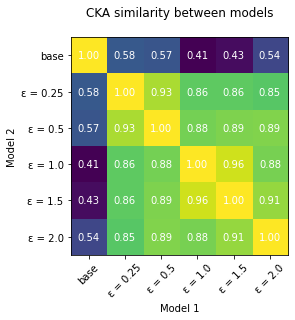

In [24]:
fig, ax = plt.subplots()
im = ax.imshow(heatmap_data3)

model_names = ['base', '\u03b5 = 0.25', '\u03b5 = 0.5', '\u03b5 = 1.0', '\u03b5 = 1.5', '\u03b5 = 2.0']

ax.set_title('CKA similarity between models\n')

ax.set_xlabel('Model 1')
ax.set_ylabel('Model 2')
ax.set_xticks(np.arange(len(model_names)))
ax.set_yticks(np.arange(len(model_names)))
ax.set_xticklabels(model_names, rotation=45)
ax.set_yticklabels(model_names)

for i in range(len(cifar_models)):
    for j in range(len(cifar_models)):
        text = ax.text(i, j, '{:.2f}'.format(heatmap_data3[i][j]),
                       ha="center", va="center", color="w")

plt.show

In [20]:
# for i in range(6):
#     print((torch.argmax(cifar_models[i](cifar_image_data[:3000]), axis=1) == cifar_image_labels[:3000]).sum().detach().cpu().numpy() / 3000)